# Mixed_vae class and its methods

Following methods are implemented:

1. custom_loss
   * Only needed, when updating model parameters
2. encode
   * Compresses input data to real valued vector
3. synthetic_data
   * Creates synthetic data. Sample size
4. likelihood
   * Calculates probability estimate for data point
5. reconstruct_logProbs
   * Calculates reconstruction error for input data
   
Before demonstrating their use we have to create VAE-model. Below is the same data preprocessing and model fitting routine, that can be found in previous notebooks.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Change working directory
os.chdir('..')

from data_processing import *
from vaeMixed import VAE_mixed
from training import training_loop

#Preprocess data
X = pd.read_csv('Data/prostateSurvival.csv')
data_dict = data_dictionary(X)
variable_types = ["cat", "cat", "cat", "int_negBin", "cat"]
X_input, X_dict, realisation_counts, = get_inputs_outputs(X, data_dict, variable_types)
decoder_int_output_size = decoder_int_output_layer_size(variable_types)

#Create & fit the model
z_dim = 3
model = VAE_mixed(X, X_dict, z_dim, 40, 40, realisation_counts, variable_types, decoder_int_output_size)
batch_size = 100
optimizer_learning_rate = 0.05
epochs = 1
model, losses = training_loop(model, X, epochs, batch_size, optimizer_learning_rate, X_input, X_dict)


0


# Encode-method
VAEs encoder compresses data and the compressed data should follow standard normal distribution. Let's create a quick and simple visual quality check to if its the case.

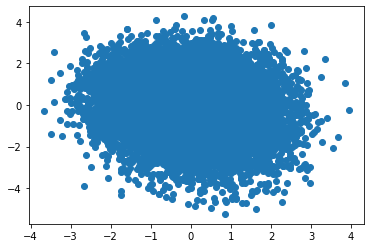

In [2]:
z = model.encode(X_input).numpy()
plt.scatter(z[:,0], z[:,1])

It is working. Compressed data could be thought as a new representation of the original data point. In electronical health records one visit to doctor often consists of multiple diagnose, procedure and atc-codes. Combining multiple sparse categorical variables can be hard and real valued representations could be much more compact than them.

# Synthetic_data-method

Creating synthetic data is easy. Just choose the sample size and use the method.

In [3]:
#Sample size
n = 3

#Create synthetic data
synthetic_data = model.synthetic_data(n)
synthetic_data

{'grade': array([[1, 0],
        [1, 0],
        [1, 0]]),
 'stage': array([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]]),
 'ageGroup': array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0]]),
 'survTime': array([[50.],
        [22.],
        [33.]], dtype=float32),
 'status': array([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]])}

We can use function synthetic_Data_to_original to convert numeric synthetic data to original form.

In [5]:
from data_processing import synthetic_Data_to_original

#Convert data
Xs = synthetic_Data_to_original(synthetic_data, X.columns, data_dict, variable_types)
Xs

,grade,stage,ageGroup,survTime,status
0,mode,T1c,66-69,50.0,2
1,mode,T1ab,66-69,22.0,0
2,mode,T2,70-74,33.0,2


# Likelihood-method

# Reconstruct_logProbs-method

This method calculates reconstruction error for each variable of the data point. Actually it is not an error but a log-probability for datapoint assuming distribution parameterized by the decoder. By summing the log-probabilities and getting an additive inverse of it one gets outlier score for the data point.

Next we get the log-probabilities for subset of the original data.

In [6]:
#Get subset
X_subset = X[1:5]
X_input_subset, X_dict_subset, realisation_counts, = get_inputs_outputs(X_subset, data_dict, variable_types)
model.reconstruct_logProbs(X_input_subset, X_dict_subset)

{'grade': array([-0.29159376, -1.3828624 , -0.30300838, -0.28901955], dtype=float32),
 'stage': array([-1.8880634 , -1.3355405 , -0.63423616, -1.0525826 ], dtype=float32),
 'ageGroup': array([-1.1823957, -0.9907665, -1.9366844, -1.5940101], dtype=float32),
 'survTime': array([-4.25453  , -4.2615967, -4.0404367, -4.374206 ], dtype=float32),
 'status': array([-0.31533244, -0.4296596 , -0.42556578, -0.3240105 ], dtype=float32)}

We can visualize outlier scores for variable survTime using a density plot. We can see that the distribution has a longer left tail. 

<AxesSubplot:ylabel='Density'>

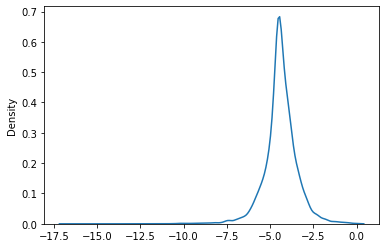

In [7]:
outlier_score_survTime = model.reconstruct_logProbs(X_input, X_dict)['survTime']
sns.kdeplot(outlier_score_survTime)

VAE is very effective in finding outliers in electronic health records, where data includes sparse categorical variables such as diagnose codes.